In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, accuracy_score, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df_raw = pd.read_csv('/content/Crop_recommendationV2.csv')
df_raw.head()

,N,P,K,temperature,humidity,ph,rainfall,label,soil_moisture,soil_type,...,organic_matter,irrigation_frequency,crop_density,pest_pressure,fertilizer_usage,growth_stage,urban_area_proximity,water_source_type,frost_risk,water_usage_efficiency
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,29.446064,2,...,3.121395,4,11.743910,57.607308,188.194958,1,2.719614,3,95.649985,1.193293
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,12.851183,3,...,2.142021,4,16.797101,74.736879,70.963629,1,4.714427,2,77.265694,1.752672
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,29.363913,2,...,1.474974,1,12.654395,1.034478,191.976077,1,30.431736,2,18.192168,3.035541
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,26.207732,3,...,8.393907,1,10.864360,24.091888,55.761388,3,10.861071,3,82.818720,1.273341
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,28.236236,2,...,5.202285,3,13.852910,38.811481,185.259702,2,47.190777,3,25.466499,2.578671


In [4]:
print(df_raw.columns)

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label',
       'soil_moisture', 'soil_type', 'sunlight_exposure', 'wind_speed',
       'co2_concentration', 'organic_matter', 'irrigation_frequency',
       'crop_density', 'pest_pressure', 'fertilizer_usage', 'growth_stage',
       'urban_area_proximity', 'water_source_type', 'frost_risk',
       'water_usage_efficiency'],
      dtype='object')


In [5]:
print(df_raw.isnull().values.any())

False


In [6]:
# move target column 'label' to be the last column

df = df_raw.copy(deep=True)
df = df.iloc[:,[0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,7]]

In [7]:
# train-test split
# the test set will contain one-tenth of the observations for each label

crops = df['label'].unique()
idx_test = []

random.seed(27)
for i in range(len(crops)):
    crop_idx = df.index[df['label']==crops[i]].tolist()
    crop_idx_test = random.sample(crop_idx, len(crop_idx)//10)
    idx_test += crop_idx_test

df_test = df.iloc[idx_test]
df = df.drop(idx_test)

EDA

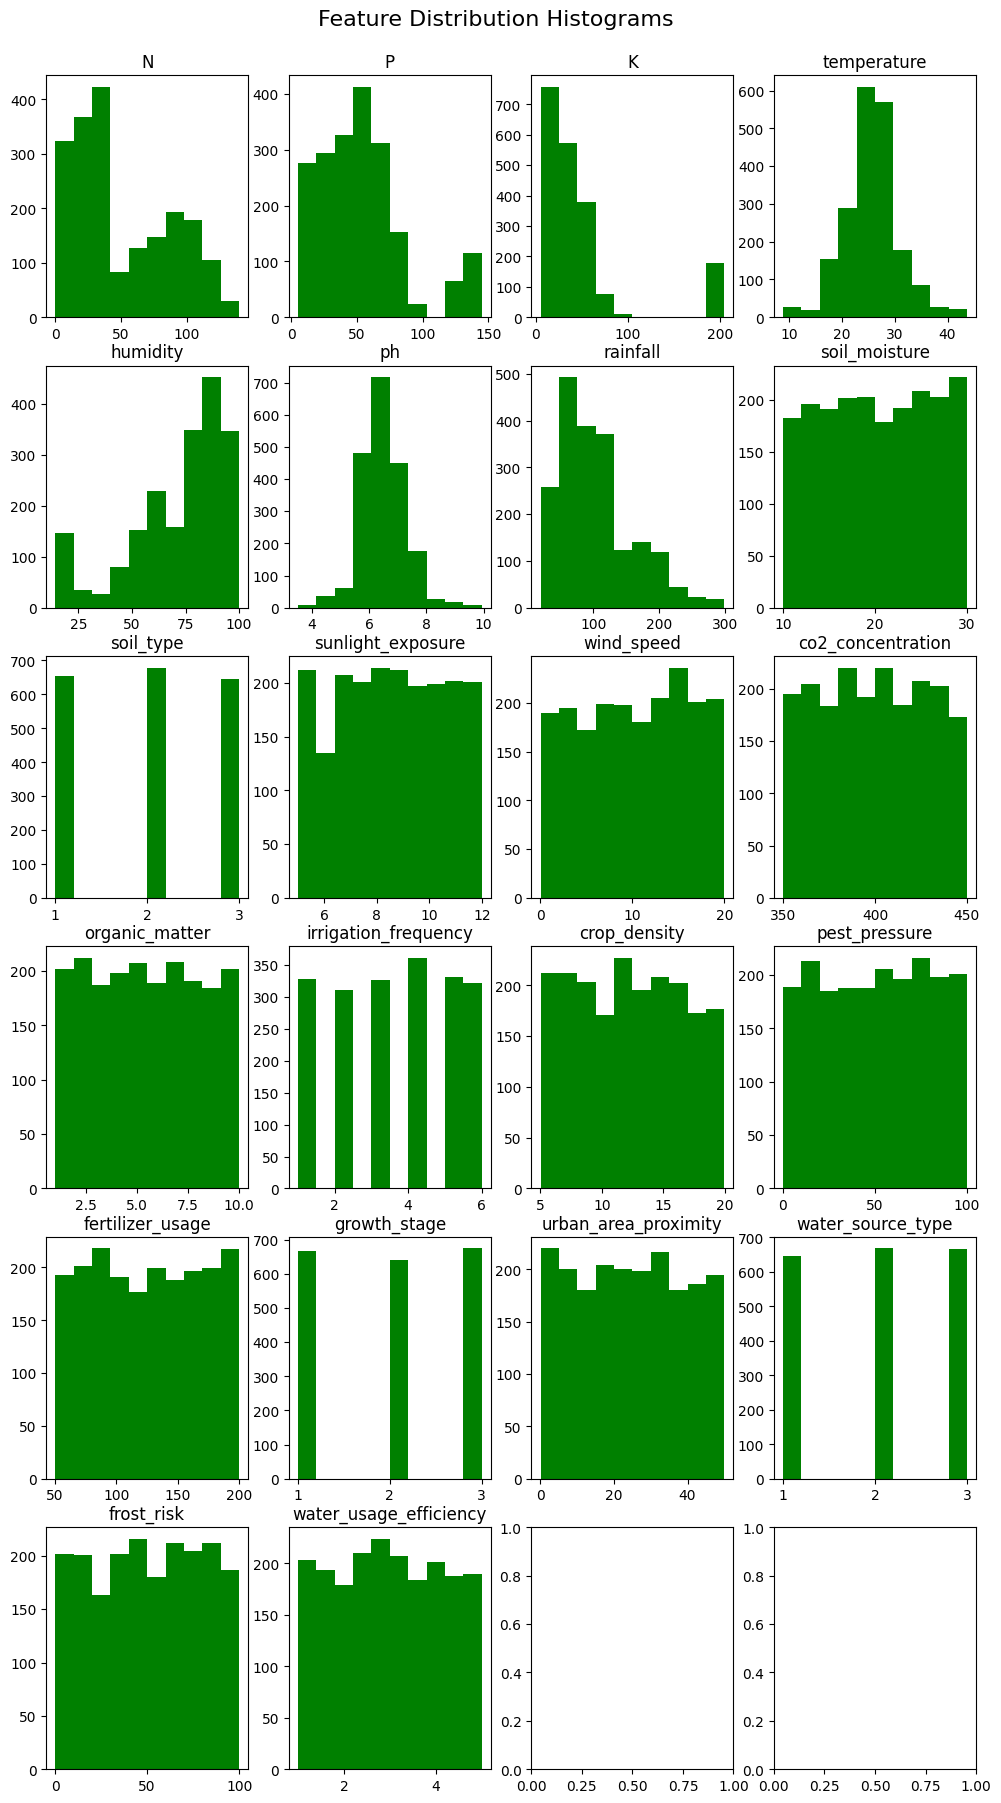

In [8]:
fig, axs = plt.subplots(6,4, figsize=(12,22), constrained_layout=False)
fig.suptitle('Feature Distribution Histograms', y=0.91, fontsize=16)

for i in range(22):
    axs[i//4, i%4].hist(df.iloc[:,i], color='green')
    axs[i//4, i%4].set_title(df.columns[i])

In [11]:
df.loc[:,'soil_type'].replace(1, 'sandy', inplace=True)
df.loc[:,'soil_type'].replace(2, 'loamy', inplace=True)
df.loc[:,'soil_type'].replace(3, 'clay', inplace=True)

df.loc[:,'growth_stage'].replace(1, 'seedling', inplace=True)
df.loc[:,'growth_stage'].replace(2, 'vegetative', inplace=True)
df.loc[:,'growth_stage'].replace(3, 'flowering', inplace=True)

df.loc[:,'water_source_type'].replace(1, 'river', inplace=True)
df.loc[:,'water_source_type'].replace(2, 'groundwater', inplace=True)
df.loc[:,'water_source_type'].replace(3, 'recycled', inplace=True)

# get dummies
df_dummies = pd.get_dummies(df)

# remove redundant categories
df_dummies = df_dummies.drop(['soil_type_clay', 'growth_stage_flowering', 'water_source_type_recycled'], axis=1)

<ipython-input-11-5b9282fc3491>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,'soil_type'].replace(1, 'sandy', inplace=True)
<ipython-input-11-5b9282fc3491>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

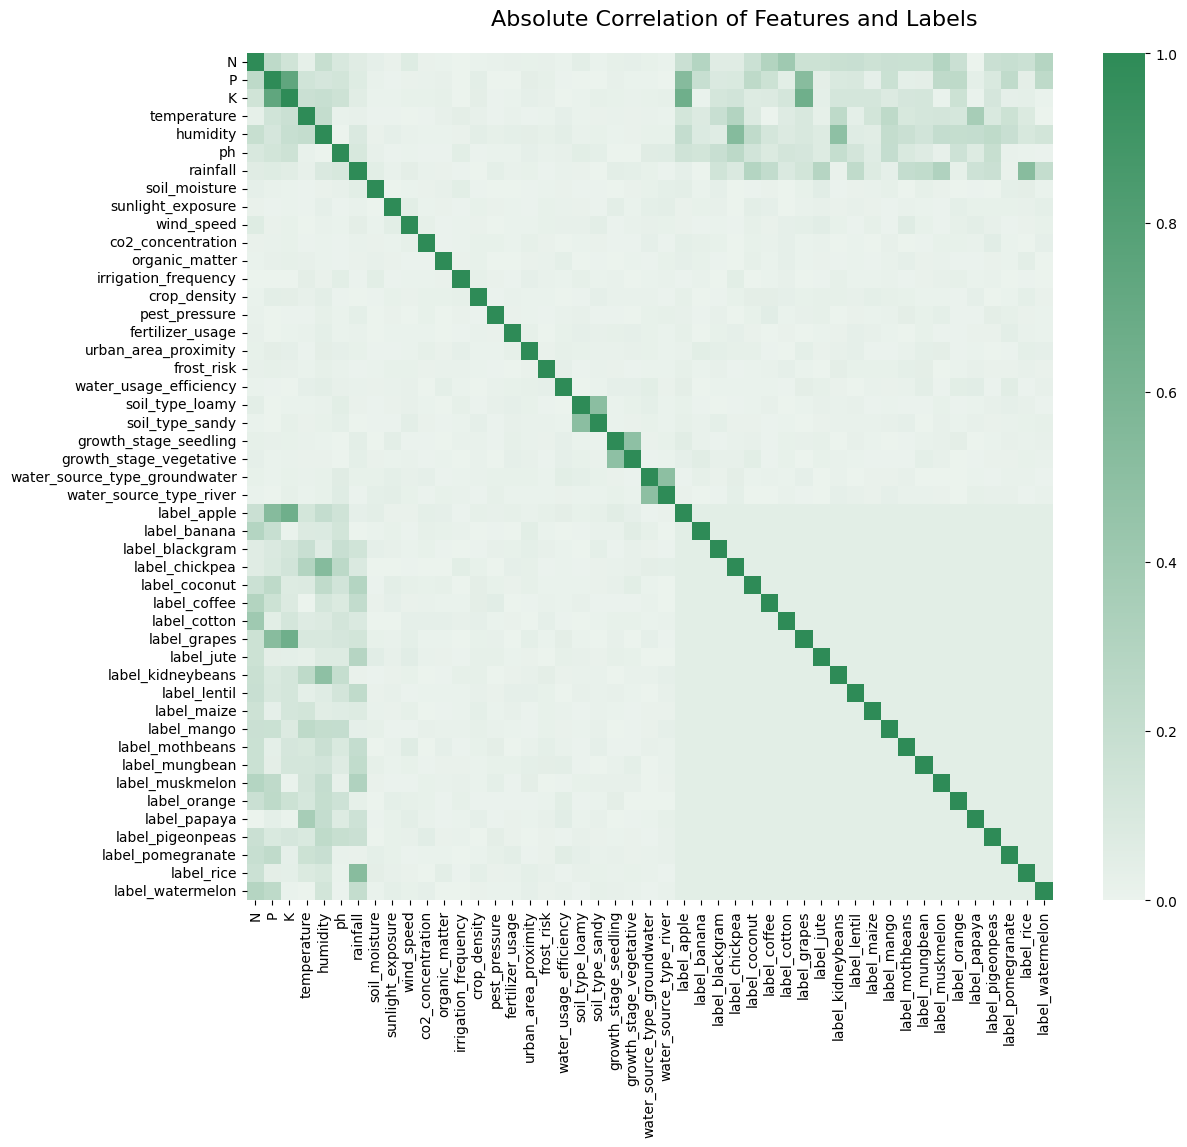

In [12]:
corr_mat = np.abs(df_dummies.corr())

fig, ax = plt.subplots(figsize=(13, 11))
fig.suptitle('Absolute Correlation of Features and Labels', y=0.92, fontsize=16)
sns.heatmap(corr_mat, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

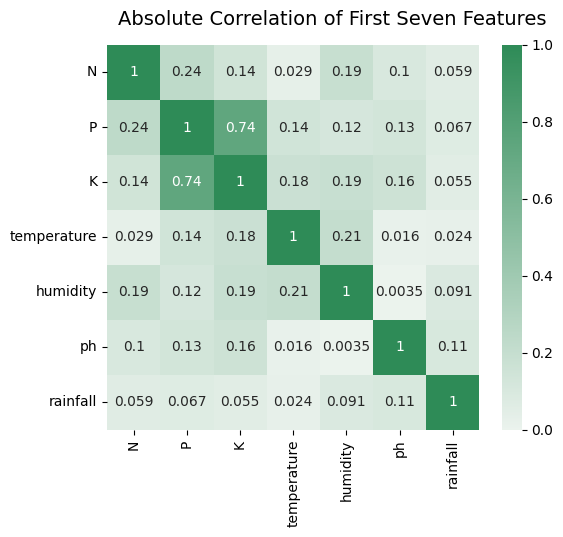

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))
fig.suptitle('Absolute Correlation of First Seven Features', y=0.95, fontsize=14)

sns.heatmap(corr_mat.iloc[0:7,0:7], annot=True, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

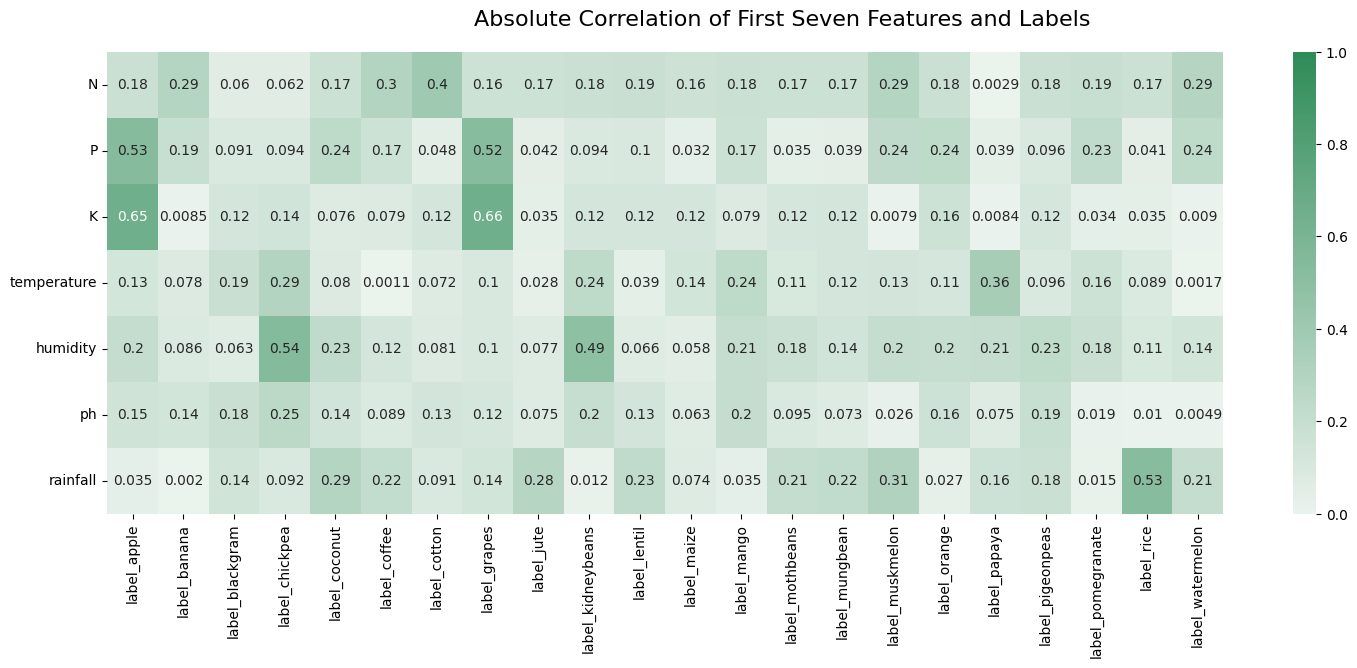

In [14]:

fig, ax = plt.subplots(figsize=(18, 6))
fig.suptitle('Absolute Correlation of First Seven Features and Labels', y=0.95, fontsize=16)

sns.heatmap(corr_mat.iloc[0:7,25:], annot=True, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

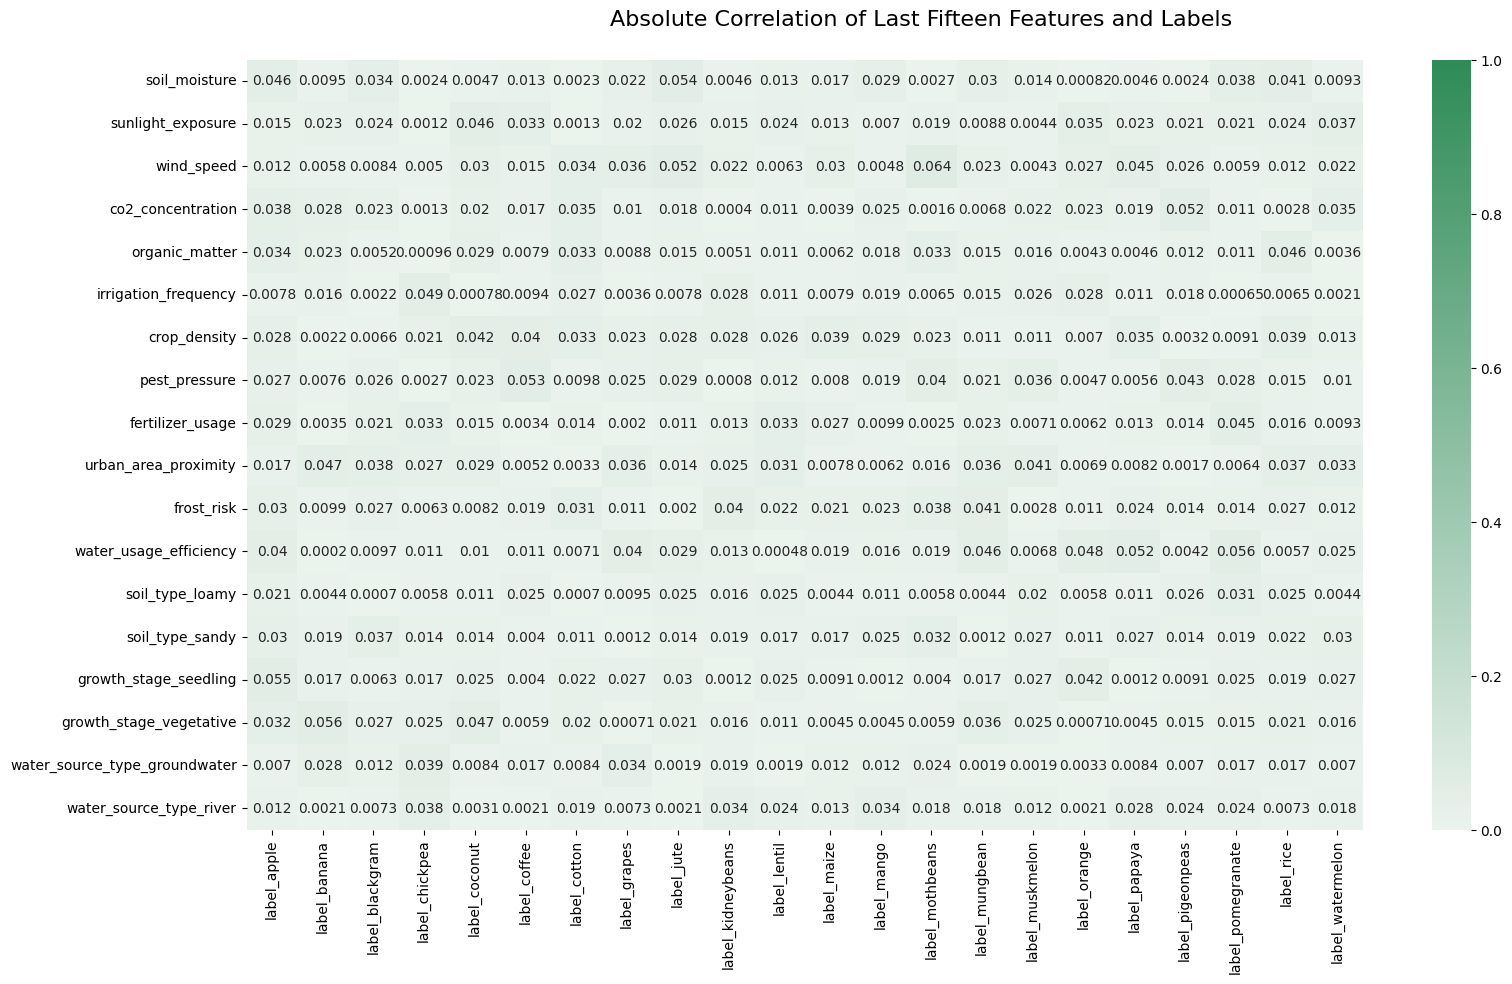

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))
fig.suptitle('Absolute Correlation of Last Fifteen Features and Labels', y=0.93, fontsize=16)

sns.heatmap(corr_mat.iloc[7:25,25:], annot=True, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

In [16]:
df_sim = df_raw.copy(deep=True)
df_sim = df_sim.iloc[:,[0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,7]]
df_sim = df_sim.drop(idx_test)

df_sim = df_sim.drop(columns=df_sim.columns[7:22])

np.random.seed(29)
random.seed(30)

# generate random values from uniform distributions
# possible value ranges match the ranges of the true features
soil_moisture_sim = np.random.uniform(10, 30, len(df_sim))
soil_type_sim = random.choices([1,2,3], k=len(df_sim))
sunlight_exposure_sim = np.random.uniform(5, 12, len(df_sim))
wind_speed_sim = np.random.uniform(0, 20, len(df_sim))
co2_concentration_sim = np.random.uniform(350, 450, len(df_sim))
organic_matter_sim = np.random.uniform(1, 10, len(df_sim))
irrigation_frequency_sim = np.random.uniform(1, 6, len(df_sim))
crop_density_sim = np.random.uniform(5, 20, len(df_sim))
pest_pressure_sim = np.random.uniform(0, 100, len(df_sim))
fertilizer_usage_sim = np.random.uniform(50, 200, len(df_sim))
growth_stage_sim = random.choices([1,2,3], k=len(df_sim))
urban_area_proximity_sim = np.random.uniform(0, 50, len(df_sim))
water_source_type_sim = random.choices([1,2,3], k=len(df_sim))
frost_risk_sim = np.random.uniform(0, 100, len(df_sim))
water_usage_efficiency_sim = np.random.uniform(1, 5, len(df_sim))

df_sim['soil_moisture_sim'] = soil_moisture_sim
df_sim['soil_type_sim'] = soil_type_sim
df_sim['sunlight_exposure_sim'] = sunlight_exposure_sim
df_sim['wind_speed_sim'] = wind_speed_sim
df_sim['co2_concentration_sim'] = co2_concentration_sim
df_sim['organic_matter_sim'] = organic_matter_sim
df_sim['irrigation_frequency_sim'] = irrigation_frequency_sim
df_sim['crop_density_sim'] = crop_density_sim
df_sim['pest_pressure_sim'] = pest_pressure_sim
df_sim['fertilizer_usage_sim'] = fertilizer_usage_sim
df_sim['growth_stage_sim'] = growth_stage_sim
df_sim['urban_area_proximity_sim'] = urban_area_proximity_sim
df_sim['water_source_type_sim'] = water_source_type_sim
df_sim['frost_risk_sim'] = frost_risk_sim
df_sim['water_usage_efficiency_sim'] = water_usage_efficiency_sim

# convert cagetorical features from numerical
df_sim.loc[:,'soil_type_sim'].replace(1, 'sandy', inplace=True)
df_sim.loc[:,'soil_type_sim'].replace(2, 'loamy', inplace=True)
df_sim.loc[:,'soil_type_sim'].replace(3, 'clay', inplace=True)

df_sim.loc[:,'growth_stage_sim'].replace(1, 'seedling', inplace=True)
df_sim.loc[:,'growth_stage_sim'].replace(2, 'vegetative', inplace=True)
df_sim.loc[:,'growth_stage_sim'].replace(3, 'flowering', inplace=True)

df_sim.loc[:,'water_source_type_sim'].replace(1, 'river', inplace=True)
df_sim.loc[:,'water_source_type_sim'].replace(2, 'groundwater', inplace=True)
df_sim.loc[:,'water_source_type_sim'].replace(3, 'recycled', inplace=True)

# get dummies of categorical predictors and labels
df_sim_dummies = pd.get_dummies(df_sim)

# remove redundant categories
df_sim_dummies = df_sim_dummies.drop(['soil_type_sim_clay', 'growth_stage_sim_flowering', 'water_source_type_sim_recycled'], axis=1)

# reorder columns
df_sim_dummies = df_sim_dummies.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,
                        41,42,43,44,45,46,
                        19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]]

<ipython-input-16-46a0918d4524>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sim.loc[:,'soil_type_sim'].replace(1, 'sandy', inplace=True)
<ipython-input-16-46a0918d4524>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

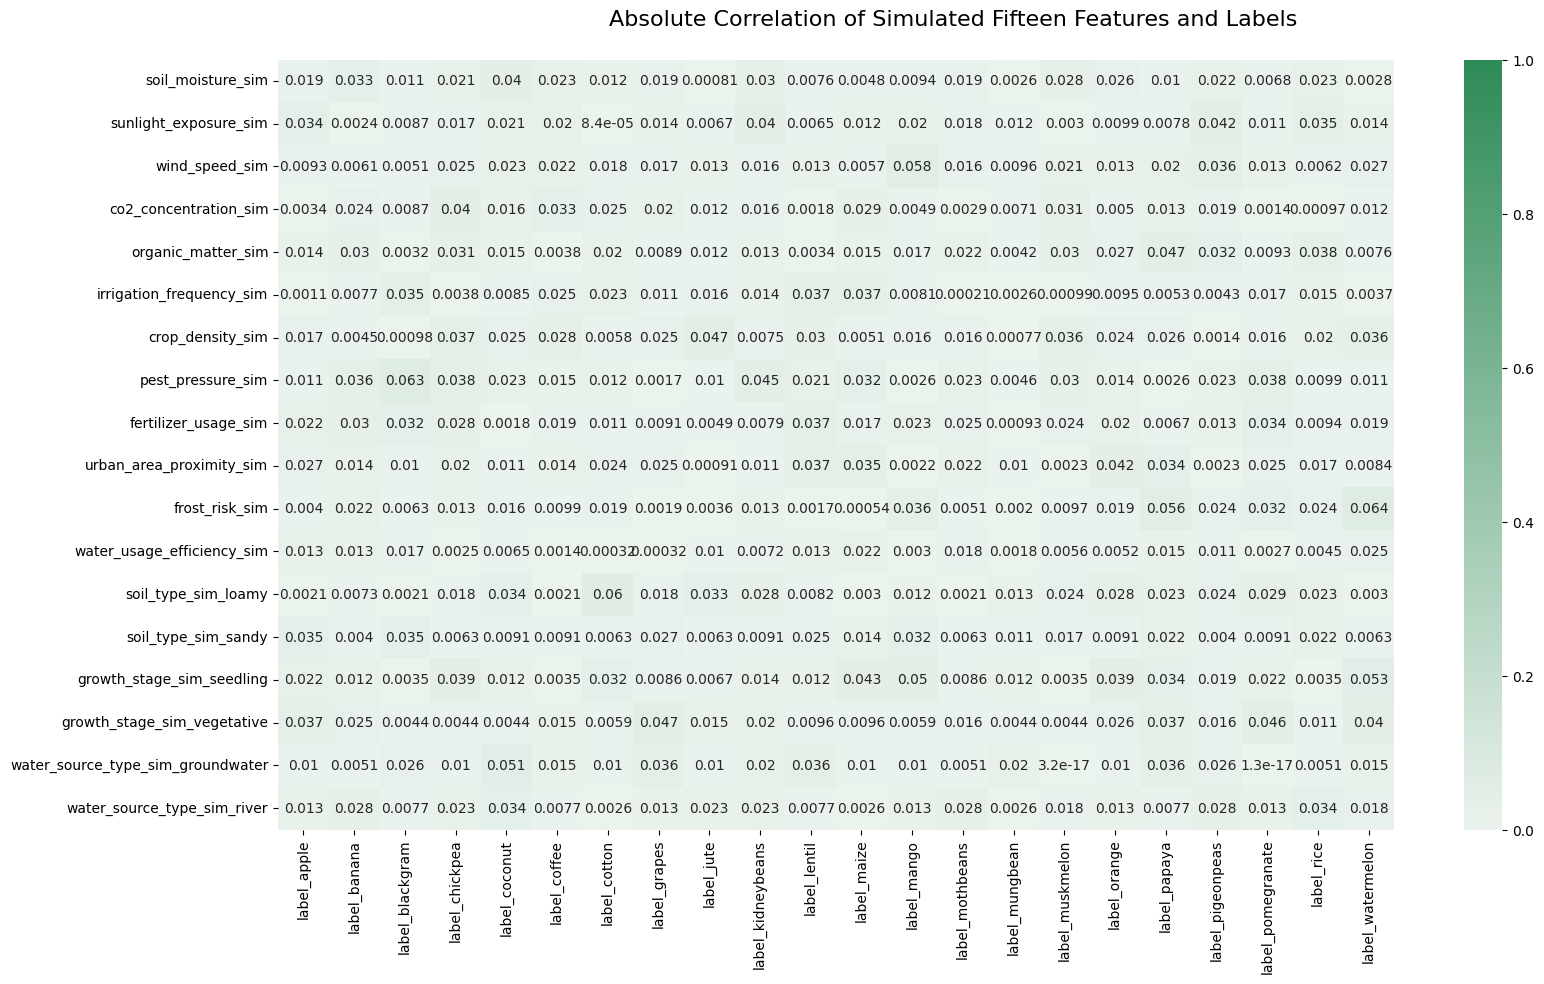

In [17]:

corr_mat_sim = np.abs(df_sim_dummies.corr())

fig, ax = plt.subplots(figsize=(18, 10))
fig.suptitle('Absolute Correlation of Simulated Fifteen Features and Labels', y=0.93, fontsize=16)

sns.heatmap(corr_mat_sim.iloc[7:25,25:], annot=True, ax=ax, vmin=0, vmax=1,
            cmap=sns.light_palette('seagreen', as_cmap=True))
plt.show()

In [18]:
df_no_labels = df_dummies.iloc[:,0:7]
features = df_no_labels.columns
for i in range(len(features)):
    print(features[i] + ':', variance_inflation_factor(df_no_labels.values, i))

N: 3.1716784142534724
P: 9.002769168422487
K: 5.334749174722414
temperature: 23.494297201864565
humidity: 15.115480325894925
ph: 26.08149994333623
rainfall: 4.362548805101728


In [19]:
scaler = StandardScaler()

X_full = scaler.fit_transform(df_dummies.iloc[:,0:25])
X_sim = scaler.fit_transform(df_sim_dummies.iloc[:,0:25])
X_main = scaler.fit_transform(df_dummies.iloc[:,0:7])

y = df['label']

In [28]:
def precision_for_class(y_true, y_pred, class_label):
    # Convert to binary problem (one-vs-rest)
    y_true_binary = (y_true == class_label)
    y_pred_binary = (y_pred == class_label)
    return precision_score(y_true_binary, y_pred_binary)

# Create custom scorers for each crop class
scorer_dict = {}
for crop in crops:
    # Create a scorer for this specific class using the custom function
    scorer_dict[f'precision_{crop}'] = make_scorer(
        lambda y_true, y_pred, crop=crop: precision_for_class(y_true, y_pred, crop)
    )

# Add macro-average precision scorer
scorer_dict['ave_precision'] = make_scorer(precision_score, average='macro')

# Model with full feature set
log_model_full = LogisticRegression(max_iter=200)
log_CV_full = cross_validate(log_model_full, X_full, y, cv=10, return_train_score=True, scoring=scorer_dict)

# Model with simplified feature set
log_model_sim = LogisticRegression(max_iter=200)
log_CV_sim = cross_validate(log_model_sim, X_sim, y, cv=10, return_train_score=True, scoring=scorer_dict)

# Model with main feature set
log_model_main = LogisticRegression(max_iter=200)
log_CV_main = cross_validate(log_model_main, X_main, y, cv=10, return_train_score=True, scoring=scorer_dict)

# Calculate average precision metrics
full_train_ave_precision = np.mean(log_CV_full['train_ave_precision'])
full_test_ave_precision = np.mean(log_CV_full['test_ave_precision'])
sim_train_ave_precision = np.mean(log_CV_sim['train_ave_precision'])
sim_test_ave_precision = np.mean(log_CV_sim['test_ave_precision'])
main_train_ave_precision = np.mean(log_CV_main['train_ave_precision'])
main_test_ave_precision = np.mean(log_CV_main['test_ave_precision'])

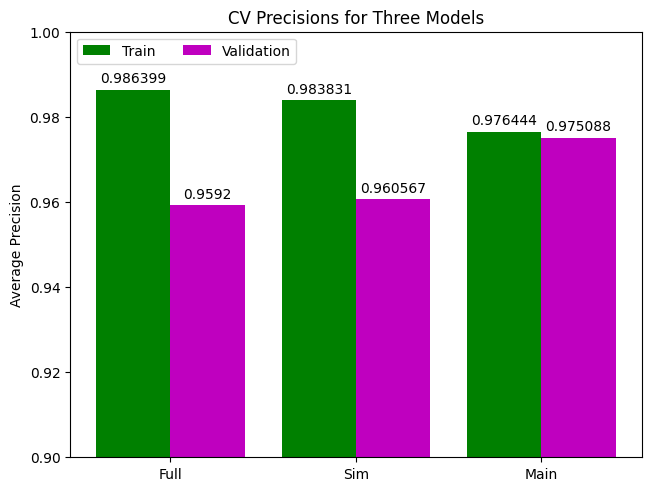

In [29]:
feature_groups = ('Full', 'Sim', 'Main')
CV_scores = {
    'Train': (full_train_ave_precision, sim_train_ave_precision, main_train_ave_precision),
    'Validation': (full_test_ave_precision, sim_test_ave_precision, main_test_ave_precision)
}

x = np.arange(len(feature_groups))
width = 0.4
multiplier = 0.5
colors = ['green', 'm']
c = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in CV_scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[c])
    ax.bar_label(rects, padding=3)
    multiplier += 1
    c = 1

ax.set_ylabel('Average Precision')
ax.set_title('CV Precisions for Three Models')
ax.set_xticks(x + width, feature_groups)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0.9, 1)

plt.show()

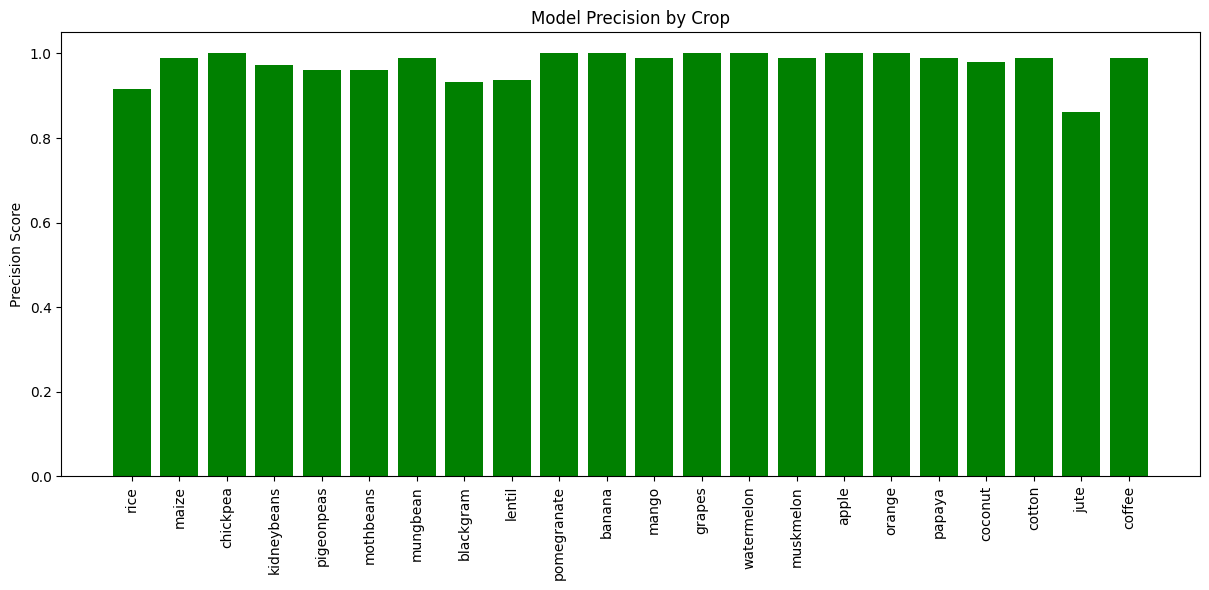

In [31]:
crop_scores = []
for crop in crops:
    key = f'test_precision_{crop}'
    crop_scores.append(np.mean(log_CV_main[key]))

plt.figure(figsize=(12, 6))
plt.bar(crops, crop_scores, color='green')
plt.title('Model Precision by Crop')
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('Precision Score')
plt.show()